# Import packages needed for mappdf demo

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import pearsonr

from diffpy.pdfgetx import PDFGetter, PDFConfig

# utils for mapPDF
from utils import *

# bSeabornStyle()

# Define filepath to informations

In [2]:
# defined example files
meta_data_fp = 'meta/20161115-220716_grid_scan_md2.txt'
chi_dir = 'chi/'


# Load raw I(Q) data

In [3]:
pdf_params = dict(qmaxinst=17, qmin=0.8, qmax=17, dataformat='Qnm',
                   rmin=0.0, rmax=100.0, rstep=0.01)
# load lookup table
# optional; to exclude function
qoi_colmns  = ['diff_x', 'diff_y', 'filename', 'composition']
df = mappdf_load_chi(meta_data_fp, qoi_columns=qoi_colmns, root=chi_dir)
# process the data
process_chi_df(df, pdf_params, 
               background=5, iq_pearson_data=5, gr_pearson_data=5)

1.73185619456


/home/christopher/dev/mappdf/demo/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **pdf_parameters)[1]


In [4]:
# view the first 5 rows for example
df.head()

,diff_x,diff_y,filename,composition,q,iq,iq_pearson,corrected_iq,gr,gr_pearson
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.7301698, 5.7302208...",0.992205,"[-5.0, -5.0, -5.0, -5.0, -5.0, 0.7301698, 0.73...","[0.0, 0.000210682320665, 0.000415885633601, 0....",0.997211
1,9.4,24.44,Catalyst_Array_DenseMap_075785_0002.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.0435905, 4.0436268...",0.999389,"[-5.0, -5.0, -5.0, -5.0, -5.0, -0.9564095, -0....","[0.0, 0.000203006689042, 0.000400759686293, 0....",0.998162
2,9.4,23.44,Catalyst_Array_DenseMap_075785_0003.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0133491, 5.0133934...",0.999855,"[-5.0, -5.0, -5.0, -5.0, -5.0, 0.0133491, 0.01...","[0.0, 0.000519379691339, 0.00102417225501, 0.0...",0.998386
3,9.4,22.44,Catalyst_Array_DenseMap_075785_0004.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.7433209, 4.7433634...",0.999668,"[-5.0, -5.0, -5.0, -5.0, -5.0, -0.2566791, -0....","[0.0, 0.000454213294869, 0.000895793107491, 0....",0.998307
4,9.4,21.44,Catalyst_Array_DenseMap_075785_0005.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.9600918, 3.9601269...",0.999868,"[-5.0, -5.0, -5.0, -5.0, -5.0, -1.0399082, -1....","[0.0, 0.000349015491661, 0.000688494400298, 0....",0.998737


# Pearson map of I(Q) wrt backgrounds for first screening 

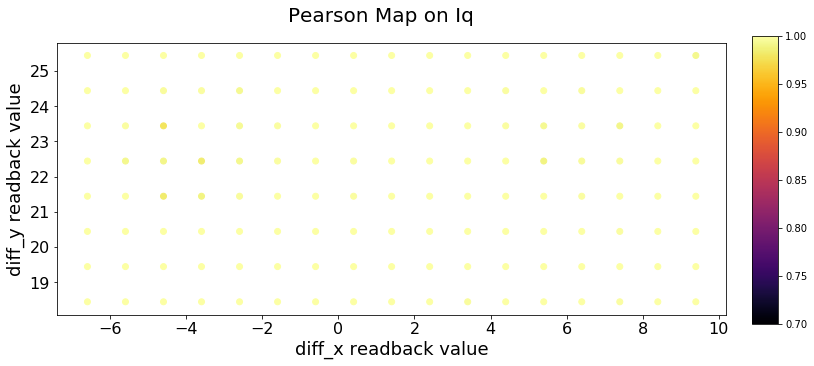

In [5]:
# create scatter plot with pearson map

# Setup plotting
plt.set_cmap('inferno')
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharey=True)
fig.suptitle('Pearson Map on Iq', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
ax.set_ylabel('diff_y readback value')
ax.set_xlabel('diff_x readback value')
conf_label_size(ax, 18)
conf_tick_size(ax, 16)

# Plot the data 
im = ax.scatter(df['diff_x'], df['diff_y'], c=df['iq_pearson'], vmin=.7)
fig.colorbar(im, cax=cax)

# Pearson map of G(r)

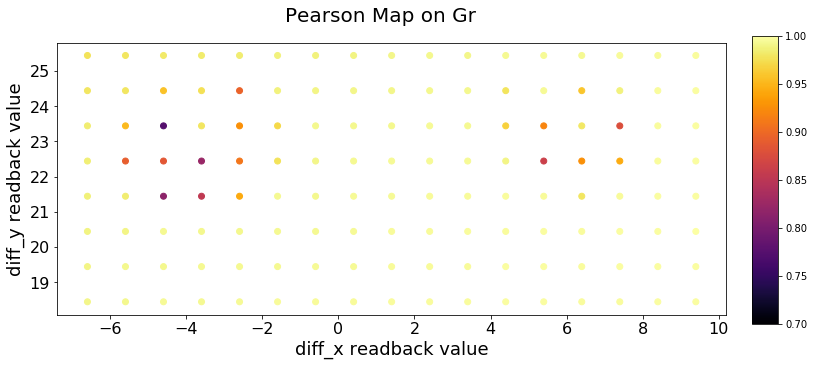

In [6]:
# create scatter plot with pearson map
# Setup plot
plt.set_cmap('inferno')
fig, ax = plt.subplots(1,1, figsize=(12, 5), sharey=True)
fig.suptitle('Pearson Map on Gr', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
ax.set_ylabel('diff_y readback value')
ax.set_xlabel('diff_x readback value')
conf_label_size(ax, 18)
conf_tick_size(ax, 16)

# Plot data
im = ax.scatter(df['diff_x'], df['diff_y'], c=df['gr_pearson'], vmin=.7)
fig.colorbar(im, cax=cax)

## Load refinements from disk

In [7]:
import pickle
with open('gridscan_pickle', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
pp = pd.DataFrame(p)
pp.head()
k = ['Cu_U1', 'Pt_U1', 'delta2_crystal1', 'lattice constant', 'rw', 's0', 'psize']
rf = pp[k]

In [8]:
# rf = pd.read_csv('refined_params.csv')
# print(list(rf.keys()))

In [9]:
d = pd.concat([df, rf], axis=1, join='inner')

## Make a heatmap of rw values using python and matplotlib functionality

An example of the heatmap plot using simple interation over the collection

In [10]:
d.head()

,diff_x,diff_y,filename,composition,q,iq,iq_pearson,corrected_iq,gr,gr_pearson,Cu_U1,Pt_U1,delta2_crystal1,lattice constant,rw,s0,psize
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.7301698, 5.7302208...",0.992205,"[-5.0, -5.0, -5.0, -5.0, -5.0, 0.7301698, 0.73...","[0.0, 0.000210682320665, 0.000415885633601, 0....",0.997211,0.000010,0.000008,27.627181,4.261763,0.899584,0.015228,34.331036
1,9.4,24.44,Catalyst_Array_DenseMap_075785_0002.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.0435905, 4.0436268...",0.999389,"[-5.0, -5.0, -5.0, -5.0, -5.0, -0.9564095, -0....","[0.0, 0.000203006689042, 0.000400759686293, 0....",0.998162,-0.214787,0.214794,16.453265,4.247973,0.932015,0.067182,26803.182348
2,9.4,23.44,Catalyst_Array_DenseMap_075785_0003.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0133491, 5.0133934...",0.999855,"[-5.0, -5.0, -5.0, -5.0, -5.0, 0.0133491, 0.01...","[0.0, 0.000519379691339, 0.00102417225501, 0.0...",0.998386,0.015756,0.016004,8.411057,4.091885,0.930254,0.171977,30.599974
3,9.4,22.44,Catalyst_Array_DenseMap_075785_0004.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.7433209, 4.7433634...",0.999668,"[-5.0, -5.0, -5.0, -5.0, -5.0, -0.2566791, -0....","[0.0, 0.000454213294869, 0.000895793107491, 0....",0.998307,-0.000492,0.000565,8.927297,4.214941,1.013352,0.033191,48.400965
4,9.4,21.44,Catalyst_Array_DenseMap_075785_0005.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.9600918, 3.9601269...",0.999868,"[-5.0, -5.0, -5.0, -5.0, -5.0, -1.0399082, -1....","[0.0, 0.000349015491661, 0.000688494400298, 0....",0.998737,0.021326,0.001256,2.712677,4.081354,0.970131,0.090714,377.206462


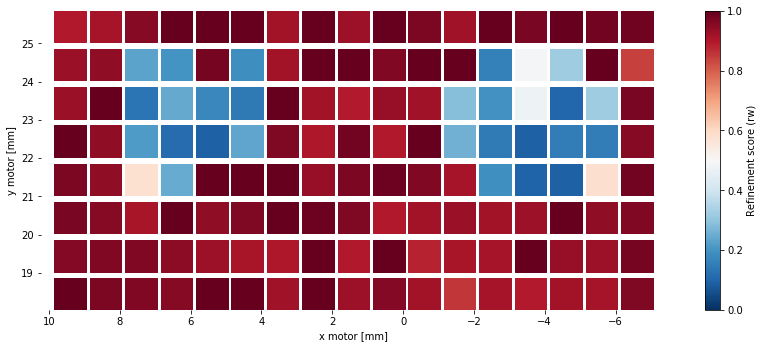

In [11]:
## define the size of the figure plot
plt.figure(figsize=(14,5.5))


## perform the iteration
plt.scatter(d['diff_x'], d['diff_y'], c=d['rw'], cmap='RdBu_r', vmin=0, vmax=1, marker='s', s=1000)

    
# add the colorbar
plot = plt.colorbar()

# Set labels
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')
plot.set_label('Refinement score (rw)')
    
# remove the box around the graph
plt.gca().invert_xaxis()
for spine in plt.gca().spines.values():
    spine.set_visible(False)

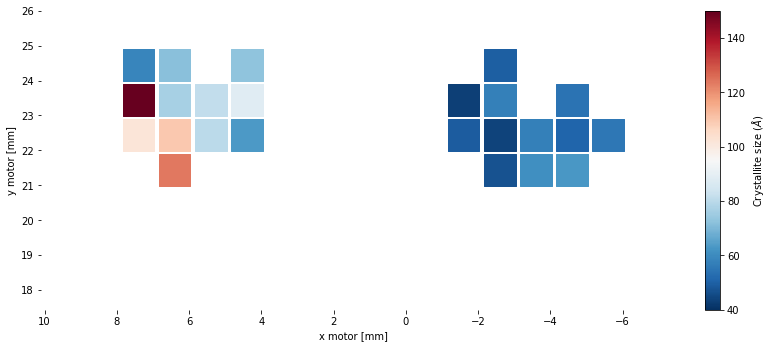

In [12]:
## define the size of the figure plot
plt.figure(figsize=(14,5.5))


## perform the iteration

where = d['rw']<0.3
plt.scatter(d['diff_x'][where], d['diff_y'][where], c=d['psize'][where], cmap = 'RdBu_r', vmin = 40, vmax = 150, marker = 's',s=1000)

    
# add the colorbar
plot = plt.colorbar()

#keep the limits as before
plt.xlim(-7.2,10.1)
plt.ylim(17.43,26)

# Set labels
plt.ylabel('y motor [mm]')
plt.xlabel('x motor [mm]')
plot.set_label('Crystallite size ($\AA$)')
    
# remove the box around the graph
plt.gca().invert_xaxis()
for spine in plt.gca().spines.values():
    spine.set_visible(False)

## Example of multiple filtering:

It is easy to define multiple criteria for filtering as well as making multiple 1D slices of the collection. Here we visualize the diffraction patterns for two arbitrary sets of refinements that we define ourselves. First we filter out all the diffraction patterns with better structural refinement results, with rw < 60%. Then, we isolate the rest, i.e. 60% < rw < 100% 


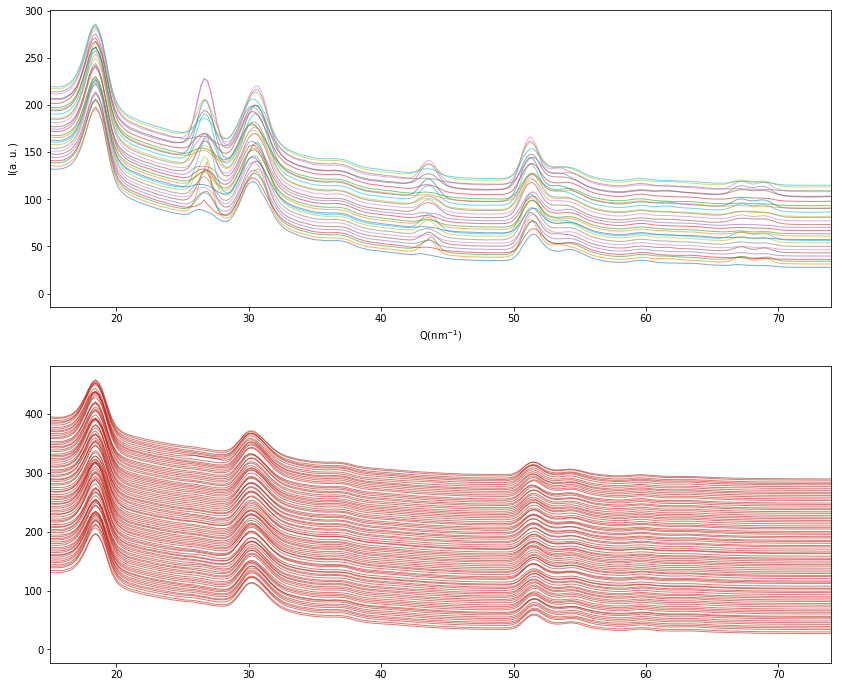

In [13]:
# make a figure
fig, ((ax1,ax2)) = plt.subplots(2, 1, figsize=[14,12])
offset_plot1=0
offset_plot2=0


## perform iteration and filtering by a criteria
x = d['q']
y = d['iq']
rw = d['rw']
for i in range(len(d)):
    if np.all(rw[i] < 0.6):
        ax1.plot(x[i], y[i] + offset_plot1, lw=1,alpha=0.6)
        offset_plot1=offset_plot1+3
        
    elif np.all(rw[i] < 1):
        ax2.plot(x[i], y[i] + offset_plot2, lw=1,alpha=0.6,color='#bb271c')
        offset_plot2=offset_plot2+3
        
# set limits to focus on the part of the diffration part
ax1.set_xlim(15,74)
ax2.set_xlim(15,74)
# set labels for x and y axes
ax1.set_ylabel('I($\mathrm{a.u.}$)');
ax1.set_xlabel('Q($\mathrm{nm^{-1}}$)');

In [14]:
d.iloc[[0]]

,diff_x,diff_y,filename,composition,q,iq,iq_pearson,corrected_iq,gr,gr_pearson,Cu_U1,Pt_U1,delta2_crystal1,lattice constant,rw,s0,psize
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi,CPtCu,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.7301698, 5.7302208...",0.992205,"[-5.0, -5.0, -5.0, -5.0, -5.0, 0.7301698, 0.73...","[0.0, 0.000210682320665, 0.000415885633601, 0....",0.997211,0.00001,0.000008,27.627181,4.261763,0.899584,0.015228,34.331036


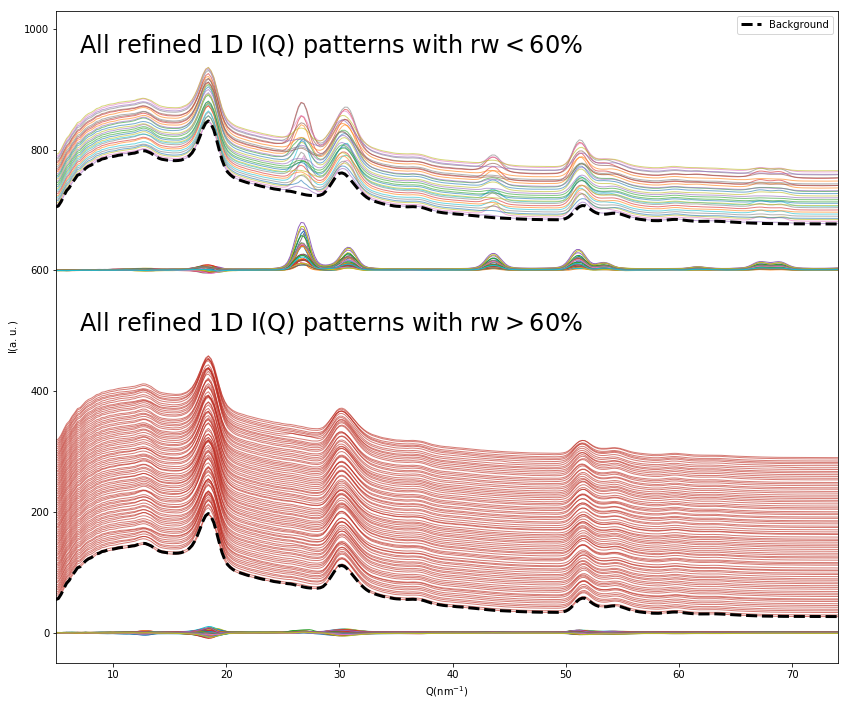

In [16]:
## Load a reference file for comparison
q, Iq = np.genfromtxt('./background/PCA_background.txt', skip_header=4).T        
ax1.plot(q,Iq,lw=3,ls='--',label = 'Background',color='black')
ax1.plot(q,Iq+650,lw=3,ls='--',color='black')

#define a figure
fig, ((ax1)) = plt.subplots(1, 1, figsize=[14,12])
offset_plot1=0
offset_plot2=0

x = d['q']
y = d['iq']
rw = d['rw']
for i in range(len(d)):
    if np.all(rw[i] < 0.6):
        ax1.plot(x[i], y[i] + 650 + offset_plot1, lw=1,alpha=0.6)
        ax1.plot(x[i], y[i]-np.interp(x[i],q,Iq)+600, lw=1)
        offset_plot1=offset_plot1+3
        
    elif np.all(rw[i] < 1):
        ax1.plot(x[i], y[i] + offset_plot2, lw=1,alpha=0.6,color='#bb271c')
        ax1.plot(x[i], y[i]-np.interp(x[i],q,Iq),lw=1)
        offset_plot2=offset_plot2+3

ax1.plot(q,Iq,lw=3,ls='--',label = 'Background',color='black')
ax1.plot(q,Iq+650,lw=3,ls='--',color='black')
# set style and labels
ax1.set_xlim(5,74)
ax1.set_ylim(-50,1030)
plt.legend()
ax1.set_ylabel('I($\mathrm{a.u.}$)') 
ax1.set_xlabel('Q($\mathrm{nm^{-1}}$)')
ax1.text(7, 500, 'All refined 1D I(Q) patterns with $\mathrm{rw>60\%}$', fontsize=24);
ax1.text(7, 960, 'All refined 1D I(Q) patterns with $\mathrm{rw<60\%}$', fontsize=24);